## Land management analysis notebook
This notebook analyzes land management data from ICOS for three locations:
* Lonzee
* Selhausen Juelich
* Voulundgaard

A few regression models are developed using these three datasets to calculate net ecosystem exchange (NEE), gross primary production (GPP), and ecosystem respiration (RECO).

First, we will read in the data.

In [1]:
import pandas as pd
import numpy as np

# Read in data from the three locations (Lonzee, Selhausen Juelich, and Voulundgaard)
# Make some changes to the columns so the dataframes can be combined later
lon_data = pd.read_csv('data/Lon_data.csv')
lon_data["Location"] = 'Lonzee'
lon_data = lon_data.rename(
    columns={"SW_IN_1_1_2":"Incoming_shortwave_radiation"})
lon_data = lon_data.replace(to_replace='#DIV/0!',value=np.nan)
print('Lonzee:',lon_data.shape)

rus_data = pd.read_csv('data/RuS_data.csv')
rus_data["Location"] = 'Selhausen Juelich'
rus_data = rus_data.drop(columns='RECO_DT_VUT_REF.1')
rus_data = rus_data.rename(
    columns={"SW_IN_1_1_2":"Incoming_shortwave_radiation"})
print('Selhausen Juelich:',rus_data.shape)

vou_data = pd.read_csv('data/vou_data.csv')
vou_data["Location"] = 'Voulundgaard'
vou_data = vou_data.rename(
    columns={"SW_IN_1_1_1":"Incoming_shortwave_radiation"})
cols_to_drop = lon_data.columns.symmetric_difference(vou_data.columns)
vou_data = vou_data.drop(columns=cols_to_drop)
print('Voulundgaard:',vou_data.shape)

# Combine data from different locations into single dataframe
frames = [lon_data,rus_data,vou_data]
data = pd.concat(frames)
print('All data:',data.shape)

C:\Users\sharp\AppData\Local\Temp\ipykernel_5052\4127769267.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  lon_data = pd.read_csv('data/Lon_data.csv')


Lonzee: (87648, 25)
Selhausen Juelich: (70128, 25)
Voulundgaard: (52608, 25)
All data: (210384, 25)


In [2]:
# Make some changes to the dataframe
# Make location 1st column
data = data[['Location'] + [col for col in data.columns if col != 'Location']]

# Replace -9999 with NaN
data = data.replace(to_replace=-9999,value=np.nan)

# Convert TIMESTAMP_START to datetime format
data['TIMESTAMP_START'] = pd.to_datetime(data['TIMESTAMP_START'].round(0),
                                         format="%Y%m%d%H%M")
data['TIMESTAMP_END'] = pd.to_datetime(data['TIMESTAMP_END'],
                                       format="%Y%m%d%H%M")

# Create year and month columns
data.insert(1,'Hour',data['TIMESTAMP_START'].dt.hour)
data.insert(1,'Day',data['TIMESTAMP_START'].dt.day)
data.insert(1,'Month',data['TIMESTAMP_START'].dt.month)
data.insert(1,'Year',data['TIMESTAMP_START'].dt.year)

# Rename some columns for personal preference
data = data.rename(
    columns={"TA_F": "Air_temperature","P_F":"Precipitation",
             "GPP_DT_VUT_REF":"GPP","NEE_VUT_REF":"NEE","RECO_DT_VUT_REF":"RECO",
             "TS_F_MDS_1":"Soil_temperature_1","TS_F_MDS_2":"Soil_temperature_2",
             "TS_F_MDS_3":"Soil_temperature_3","TS_F_MDS_4":"Soil_temperature_4",
             "TS_F_MDS_5":"Soil_temperature_5","TIMESTAMP_START":"Timestamp_start",
             "TIMESTAMP_END":"Timestamp_end","RH":"Relative_humidity",
             "G_F_MDS":"Soil_heat_flux","SWC_F_MDS_5":"Soil_water_content",
             "SWC_F_MDS_1":"Soil_water_content_1","SWC_F_MDS_2":"Soil_water_content_2",
             "SWC_F_MDS_3":"Soil_water_content_3","SWC_F_MDS_4":"Soil_water_content_4",
             "SWC_F_MDS_5":"Soil_water_content_5","TS_avg":"Avg_soil_temperature",
             "LE_F_MDS":"Sensible_heat_flux", "H_F_MDS":"Latent_heat_flux"
             })

# Remove 'RECO_NT_VUT_REF' (not sure what this is)
data = data.drop(columns=['RECO_NT_VUT_REF'])
data.head()

,Location,Year,Month,Day,Hour,Timestamp_start,Timestamp_end,Relative_humidity,NEE,Soil_heat_flux,...,Soil_water_content_4,Soil_water_content_5,Soil_temperature_1,Soil_temperature_2,Soil_temperature_3,Soil_temperature_4,Soil_temperature_5,Avg_soil_temperature,Precipitation,Incoming_shortwave_radiation
0,Lonzee,2018,1,1,0,2018-01-01 00:00:00,2018-01-01 00:30:00,NaN,-0.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN
1,Lonzee,2018,1,1,0,2018-01-01 00:30:00,2018-01-01 01:00:00,NaN,-0.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN
2,Lonzee,2018,1,1,1,2018-01-01 01:00:00,2018-01-01 01:30:00,NaN,-0.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN
3,Lonzee,2018,1,1,1,2018-01-01 01:30:00,2018-01-01 02:00:00,NaN,-0.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN
4,Lonzee,2018,1,1,2,2018-01-01 02:00:00,2018-01-01 02:30:00,NaN,0.15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN


There are lots of NaNs in the data. Some models can't handle missing data, so clean the dataframe for those models.

In [3]:
# The linear regression model used below cannot deal with missing values
cleaned_data = data.dropna(axis=0)

print('All data:', data.shape)
print('Cleaned data:', cleaned_data.shape)

All data: (210384, 28)
Cleaned data: (152654, 28)


Some of the features in the data interact with one another. For example, it makes sense that all of the soil temperatures will correlate with each other. Also, it's reasonable to assume that the air temperature and soil temperature at not independent of each other. 

Let's plot the pairwise correlations of all of the features and labels:

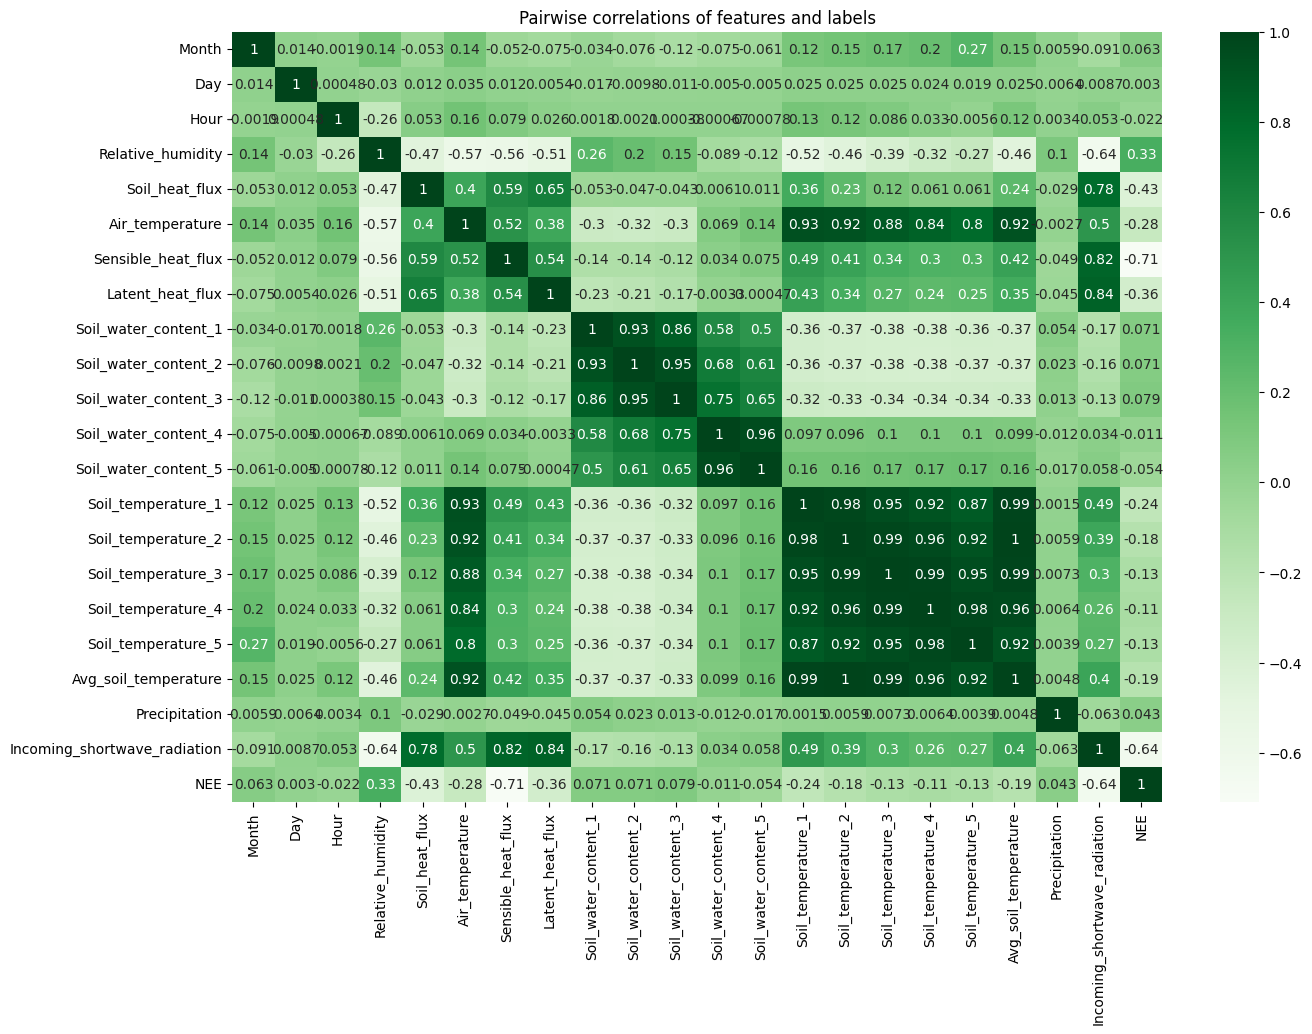

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Select features and labels
all_labels = ['GPP','NEE','RECO']
all_features = ['Month', 'Day', 'Hour', 'Relative_humidity', 
        'Soil_heat_flux', 'Air_temperature', 'Soil_water_content_1', 
        'Soil_water_content_2', 'Soil_water_content_3', 
        'Soil_water_content_4', 'Soil_water_content_5',
        'Soil_temperature_1', 'Soil_temperature_2', 'Soil_temperature_3',
        'Soil_temperature_4', 'Soil_temperature_5', 'Avg_soil_temperature',
        'Precipitation', 'Incoming_shortwave_radiation', 'Sensible_heat_flux',
        'Latent_heat_flux']
cleaned_features = list(cleaned_data.columns.intersection(all_features))

plt.figure(figsize=(15,10))
cor = cleaned_data[cleaned_features + ['NEE']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.title('Pairwise correlations of features and labels')
plt.show()

Clearly some of the features are correlated with other features. Need to select which ones to keep to create a linear model with only the reduced features.

In [5]:
reduced_features = ['Soil_water_content_3','Soil_temperature_1','Sensible_heat_flux']

Next create some methods to test and analyze our models:

In [6]:
# Method that tests performance of model given features X and labels y
def test_model(model,X,y,ttl='',do_show_plot=True):
    predictions = model.predict(X)
    mse = mean_squared_error(y,predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y,predictions)

    if do_show_plot:
        fig, ax = plt.subplots(1,1,figsize=(5,3))

        ax.scatter(y, predictions)
        plt.xlabel('Actual labels')
        plt.ylabel('Predicted labels')
        plt.annotate(('MSE: ' + str("{:.3f}".format(mse))),xy=(475, 275), xycoords='figure pixels')
        plt.annotate(('RMSE: ' + str("{:.3f}".format(rmse))),xy=(475, 255), xycoords='figure pixels')
        plt.annotate(('R2: ' + str("{:.3f}".format(r2))),xy=(475, 235), xycoords='figure pixels')

        # overlay the regression line
        z = np.polyfit(np.squeeze(np.asarray(y)), predictions, 1)
        p = np.poly1d(np.squeeze(z))
        plt.plot(y,p(y),color='magenta')
        plt.title(ttl)
        plt.show()
    else:
        fig = []
        ax = []

    return fig, ax, r2

# Method that analyzes a model (including p-values)
def calculate_p_values(lm, X, y):
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    dot_prod = (np.asarray(newX.astype(float)).T)@(np.asarray(newX.astype(float)))
    var_b = MSE*(np.linalg.inv(dot_prod).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - len(newX.columns)))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    model_analysis = pd.DataFrame()
    model_analysis["Coefficients"],model_analysis["Standard_errors"],model_analysis["t_values"],model_analysis["p_values"] = [params,sd_b,ts_b,p_values]
    model_analysis = model_analysis.set_axis(newX.columns,axis=0)

    return model_analysis

## LinearRegression
Now we can train a linear regression model. This model cannot handle missing data, so use the cleaned dataframe here.

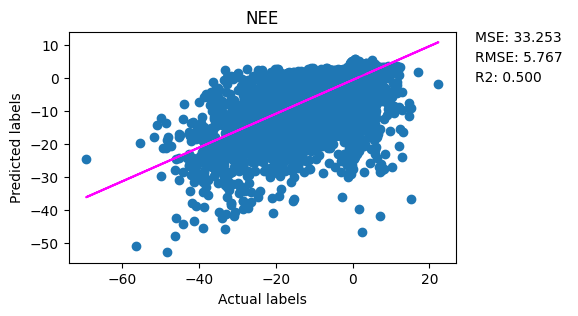

,Coefficients,Standard_errors,t_values,p_values
Constant,-0.8381,0.192,-4.361,0.0
Soil_water_content_3,0.0301,0.006,5.152,0.0
Soil_temperature_1,0.1747,0.008,22.001,0.0
Sensible_heat_flux,-0.0890,0.001,-119.140,0.0


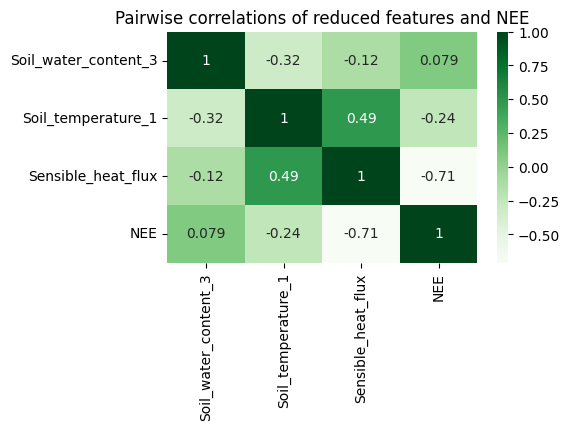

In [7]:
from sklearn.linear_model import LinearRegression

labels = ['NEE']
sorted_features = pd.DataFrame()
for label in labels:
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        cleaned_data[reduced_features], cleaned_data[label], 
        test_size=0.1, random_state=42)

    # Train linear regression model
    lin_reg_model = LinearRegression()
    fitted_lin_reg_model = lin_reg_model.fit(X_train, y_train)

    # Plot model results
    fig, ax, r2 = test_model(fitted_lin_reg_model,X_test,y_test,ttl=label)

    # Calculate p-values for all features
    model_analysis = calculate_p_values(fitted_lin_reg_model, X_test, y_test)
    # Sort p-values
    sorted_model_analysis = model_analysis.sort_values(by='p_values')
    # Store the features corresponding to the sorted p-values in the same order
    sorted_feats = sorted_model_analysis.index
    sorted_features[label] = sorted_feats
display(sorted_model_analysis)

plt.figure(figsize=(5,3))
cor = cleaned_data[reduced_features + ['NEE']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.title('Pairwise correlations of reduced features and NEE')
plt.show()

What happens if we use all features anyways?

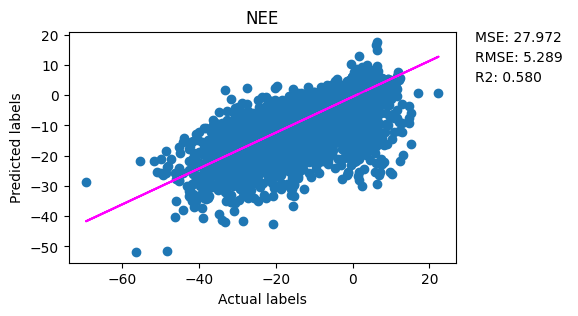

,Coefficients,Standard_errors,t_values,p_values
Constant,8.5791,0.430,19.967,0.000
Soil_water_content_5,-0.0691,0.013,-5.184,0.000
Soil_water_content_3,0.1551,0.020,7.853,0.000
Soil_water_content_1,0.0650,0.014,4.619,0.000
Latent_heat_flux,0.0715,0.002,38.764,0.000
Sensible_heat_flux,-0.0403,0.001,-31.116,0.000
Soil_water_content_2,-0.1208,0.022,-5.541,0.000
Soil_heat_flux,0.0390,0.002,16.157,0.000
Relative_humidity,-0.0850,0.004,-20.322,0.000
Hour,-0.0288,0.007,-4.173,0.000


In [8]:
from sklearn.linear_model import LinearRegression

labels = ['NEE']
sorted_features = pd.DataFrame()
for label in labels:
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        cleaned_data[cleaned_features], cleaned_data[label], 
        test_size=0.1, random_state=42)

    # Train linear regression model
    lin_reg_model = LinearRegression()
    fitted_lin_reg_model = lin_reg_model.fit(X_train, y_train)

    # Plot model results
    fig, ax, r2 = test_model(fitted_lin_reg_model,X_test,y_test,ttl=label)

    # Calculate p-values for all features
    model_analysis = calculate_p_values(fitted_lin_reg_model, X_test, y_test)
    # Sort p-values
    sorted_model_analysis = model_analysis.sort_values(by='p_values')
    # Store the features corresponding to the sorted p-values in the same order
    sorted_feats = sorted_model_analysis.index
    sorted_features[label] = sorted_feats
display(sorted_model_analysis)


This does a bit better than the model for the reduced features. 
Below we can see how the R2 value for the linear regression changes with increasing number of features.

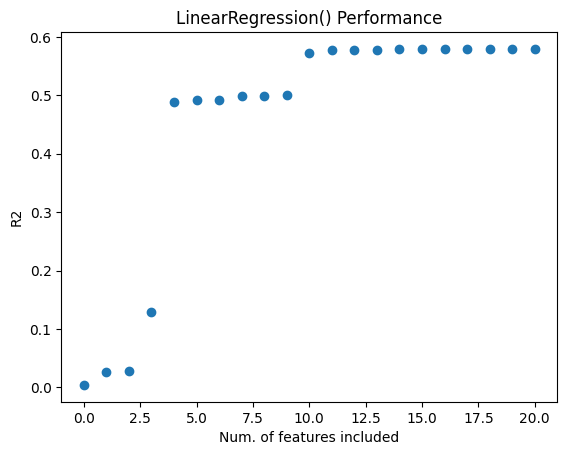

In [9]:
from sklearn.linear_model import LinearRegression

# Run the model with increasing number of features using the sorted features
labels = ['NEE']
test_features = list(sorted_features.NEE[1:])
all_r2 = []
for i in range(1,len(test_features)+1):
    features_subset = test_features[0:i]
    sorted_features = pd.DataFrame()
    for label in labels:
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            cleaned_data[features_subset], cleaned_data[label], 
            test_size=0.1, random_state=42)

        # Train linear regression model
        lin_reg_model = LinearRegression()
        fitted_lin_reg_model = lin_reg_model.fit(X_train, y_train)

        # Plot model results
        fig, ax, r2 = test_model(fitted_lin_reg_model,X_test,y_test,do_show_plot=False)
        all_r2.append(r2)

        # plt.figure(figsize=(15,10))
        # cor = data[features_subset + [label]].corr()
        # sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
        # plt.title('Pairwise correlations of features and labels')
        # plt.show()

            # Calculate p-values for all features
        model_analysis = calculate_p_values(fitted_lin_reg_model, X_test, y_test)
        # Sort p-values
        sorted_model_analysis = model_analysis.sort_values(by='p_values')
        # Store the features corresponding to the sorted p-values in the same order
        sorted_feats = sorted_model_analysis.index
        sorted_features[label] = sorted_feats
    # display(sorted_model_analysis)

# Plot R2 for increasing number of sorted features
plt.plot(all_r2,'o')
plt.title(str(lin_reg_model) + ' Performance')
plt.xlabel('Num. of features included')
plt.ylabel('R2')
plt.show()

This linear regression model didn't really do that well. It's not terrible, but surely we can do better?

## HistGradientBoostingRegressor
Next, we will try a different regressor based on decision tree learning. The HistGradientBoostingRegressor model can handle missing data. We can use this to use all of the available data. Since it's based on decision trees, it's possible that this model will overfit the data. To see if the model is overfit, we will use the model on both the test and training datasets.

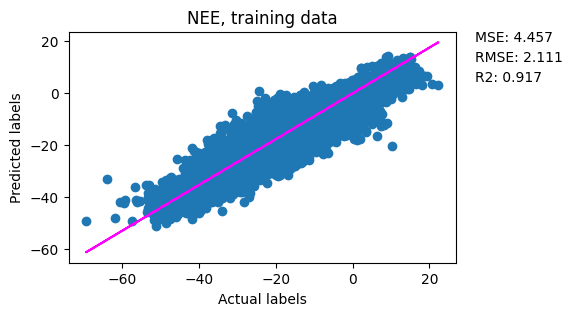

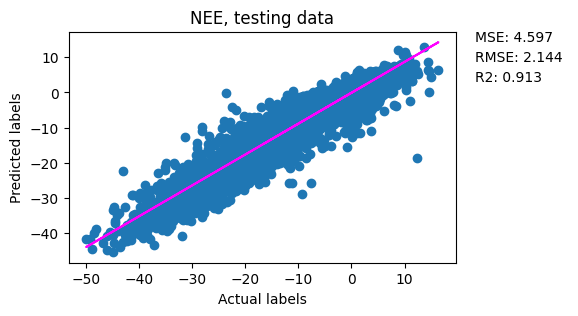

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor

for label in labels:
    X_train, X_test, y_train, y_test = train_test_split(data[all_features],data[label],
                                                        test_size=0.1, random_state=42)
    HGBR_model = HistGradientBoostingRegressor().fit(X_train, y_train)
    fig, ax, r2 = test_model(HGBR_model,X_train,y_train,ttl=label + ', training data')    
    fig, ax, r2 = test_model(HGBR_model,X_test,y_test,ttl=label + ', testing data')

In [11]:
# Save the model
import pickle
filename = 'HGBR_model.sav'
pickle.dump(HGBR_model, open(filename, 'wb'))

This model already does much better than the initial linear regression model. 

Now we can adjust the hyperparameters for the HistGradientBoostingRegressor() model to optimise the performance of this model.

In [12]:
do_model_tuning = False # If you want to re-run the tuning, do this. This will take a few minutes.
if do_model_tuning:
    import pickle

    ### Tune the hyperparameters ###
    # Check which loss function performs best
    loss_funcs = ['squared_error', 'absolute_error'] # The other loss functions for this model have restrictions on the input data and don't work with this data set as it currently is
    r2s = []
    for loss in loss_funcs:
        model = HistGradientBoostingRegressor(loss=loss).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(r2s,'o')
    ax.set_xticks([0,1])
    ax.set_xticklabels(loss_funcs)
    ax.set_xlabel('Loss function')
    ax.set_ylabel('R2')
    plt.show()

    best_loss_func = loss_funcs[np.argmax(r2s)]
    print('Best loss function:', best_loss_func)


    # Tune the learning rate
    learning_rates = np.linspace(0.1,1,25)
    r2s = []
    for lr in learning_rates:
        model = HistGradientBoostingRegressor(loss=best_loss_func,learning_rate=lr).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(learning_rates,r2s,'o')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('R2')
    plt.show()

    best_learning_rate = learning_rates[np.argmax(r2s)]
    print('Best learning rate:', best_learning_rate)


    # Tune the maximum number of trees
    max_iters = np.linspace(2,150,25).astype(int)
    r2s = []
    for mi in max_iters:
        model = HistGradientBoostingRegressor(
            loss=best_loss_func,learning_rate=best_learning_rate,max_iter=mi
            ).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(max_iters,r2s,'o')
    ax.set_xlabel('Max iter')
    ax.set_ylabel('R2')
    plt.show()

    best_max_iter = max_iters[np.argmax(r2s)]
    print('Best max iter:', best_max_iter)


    # Tune the maximum number of leaves for each tree
    max_leaf_nodess = np.linspace(2,50,25).astype(int)
    r2s = []
    for ml in max_leaf_nodess:
        model = HistGradientBoostingRegressor(
            loss=best_loss_func,learning_rate=best_learning_rate,
            max_iter=best_max_iter,max_leaf_nodes=ml
            ).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(max_leaf_nodess,r2s,'o')
    ax.set_xlabel('Max leaf nodes')
    ax.set_ylabel('R2')
    plt.show()

    best_max_leaf_nodes = max_leaf_nodess[np.argmax(r2s)]
    print('Best max leaf nodes:', best_max_leaf_nodes)


    # Tune the maximum depth of each tree
    max_depths = np.linspace(2,25,24).astype(int)
    r2s = []
    for md in max_depths:
        model = HistGradientBoostingRegressor(
            loss=best_loss_func,learning_rate=best_learning_rate,
            max_iter=best_max_iter,max_leaf_nodes=best_max_leaf_nodes,
            max_depth=md
            ).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(max_depths,r2s,'o')
    ax.set_xlabel('Max depths')
    ax.set_ylabel('R2')
    plt.show()

    best_max_depth = max_depths[np.argmax(r2s)]
    print('Best max depth:', best_max_depth)


    # Tune the minimum number of samples per leaf
    min_samples = np.linspace(2,100,50).astype(int)
    r2s = []
    for ms in min_samples:
        model = HistGradientBoostingRegressor(
            loss=best_loss_func,learning_rate=best_learning_rate,
            max_iter=best_max_iter,max_leaf_nodes=best_max_leaf_nodes,
            max_depth=best_max_depth, min_samples_leaf=ms
            ).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(min_samples,r2s,'o')
    ax.set_xlabel('Min samples leaf')
    ax.set_ylabel('R2')
    plt.show()

    best_min_samples = min_samples[np.argmax(r2s)]
    print('Best min samples per leaf:', best_min_samples)


    # Tune the L2 regularization parameter
    l2_regularizations = np.linspace(0,0.001,10)
    r2s = []
    for l2 in l2_regularizations:
        model = HistGradientBoostingRegressor(
            loss=best_loss_func,learning_rate=best_learning_rate,
            max_iter=best_max_iter,max_leaf_nodes=best_max_leaf_nodes,
            max_depth=best_max_depth, min_samples_leaf=best_min_samples,
            l2_regularization=l2
            ).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(l2_regularizations,r2s,'o')
    ax.set_xlabel('L2 regularization')
    ax.set_ylabel('R2')
    plt.show()

    best_l2 = l2_regularizations[np.argmax(r2s)]
    print('Best L2 regularization:', best_l2)


    # Tune the maximum number of bins to use for non-missing values
    max_binss = np.linspace(2,255,25).astype(int)
    r2s = []
    for mb in max_binss:
        model = HistGradientBoostingRegressor(
            loss=best_loss_func,learning_rate=best_learning_rate,
            max_iter=best_max_iter,max_leaf_nodes=best_max_leaf_nodes,
            max_depth=best_max_depth, min_samples_leaf=best_min_samples,
            l2_regularization=best_l2, max_bins=mb
            ).fit(X_train,y_train)
        fig, ax, r2 = test_model(model,X_test,y_test,do_show_plot=False)
        r2s.append(r2)

    fig, ax = plt.subplots(1,1,figsize = (5,3))
    plt.plot(max_binss,r2s,'o')
    ax.set_xlabel('Max bins')
    ax.set_ylabel('R2')
    plt.show()

    best_max_bins = max_binss[np.argmax(r2s)]
    print('Best max bins:', best_max_bins)


    ### Test tuned model ###
    tuned_HGBR_model = HistGradientBoostingRegressor(
        loss=best_loss_func,learning_rate=best_learning_rate,
        max_iter=best_max_iter,max_leaf_nodes=best_max_leaf_nodes,
        max_depth=best_max_depth, min_samples_leaf=best_min_samples,
        l2_regularization=best_l2, max_bins=best_max_bins
        ).fit(X_train,y_train)

    fig, ax, r2 = test_model(tuned_HGBR_model,X_train,y_train,ttl='Tuned model, training data')
    fig, ax, r2 = test_model(tuned_HGBR_model,X_test,y_test,ttl='Tuned model, test data')


    ### Save the tuned model ###
    filename = 'tuned_HGBR_model.sav'
    pickle.dump(tuned_HGBR_model, open(filename, 'wb'))

Read in the initial and tuned HGBR model and  test each on the training and test data.

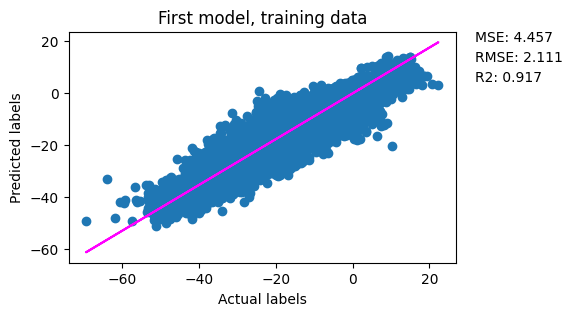

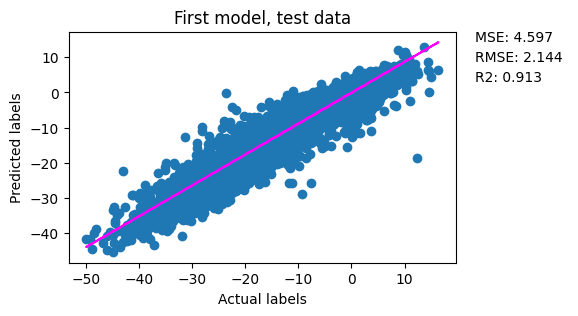

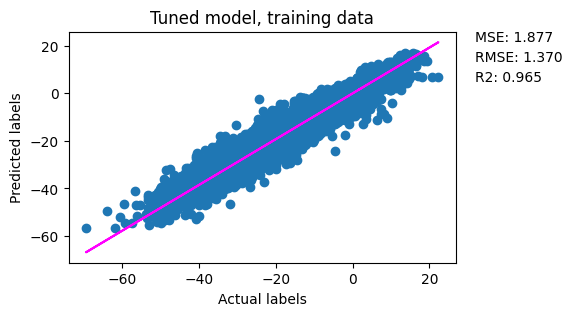

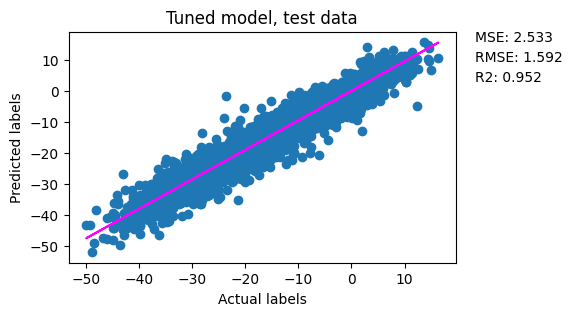

In [13]:
loaded_model = pickle.load(open('HGBR_model.sav', 'rb'))
loaded_tuned_model = pickle.load(open('tuned_HGBR_model.sav', 'rb'))

fig, ax, r2 = test_model(loaded_model,X_train,y_train,ttl='First model, training data')
fig, ax, r2 = test_model(loaded_model,X_test,y_test,ttl='First model, test data')

fig, ax, r2 = test_model(loaded_tuned_model,X_train,y_train,ttl='Tuned model, training data')
fig, ax, r2 = test_model(loaded_tuned_model,X_test,y_test,ttl='Tuned model, test data')


The tuned model does slightly better than the initial HGBR model, and both do significantly better than the linear regression model that we first trained.